# Modèle de prédiction de la perte de clientèle

In [2]:
# import des bibliothèques nécessaires
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, classification_report, confusion_matrix, mean_absolute_error, roc_auc_score, f1_score
import joblib
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

## Analyse des données

In [4]:
# Charger le fichier de données
data = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [5]:
# Afficher les 5 premiers enregistrements de données
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [6]:
# les différentes caractéristiques des données 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [7]:
data.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [8]:
# Repartition des valeurs de la variable cible
data['Churn'].value_counts(normalize=True)

Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64

Les données sont très déséquilibrées, ratio = 73:27

In [10]:
# Données manquantes
data.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

### Nettoyage des données

In [12]:
# Une copie des données
df = data.copy()

In [13]:
# Les charges totales doivent être un montant numérique. Conversion en type de données numérique
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [14]:
df[df['TotalCharges'].isnull()]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


Il y a 11 valeurs manquantes dans la colonne TotalCharges.

In [16]:
# Traitement des valeurs manquantes
df = df.dropna(subset=['TotalCharges'])
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,Yes


In [17]:
# Division les clients en classe en fonction de l'ancienneté
df['tenure_class'] = pd.cut(df['tenure'], bins=[0, 10, 20, 30, 40, 50, 60, 70, 80], labels=['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80',])
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_class
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,0-10
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,No,No,One year,No,Mailed check,56.95,1889.50,No,30-40
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,0-10
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,40-50
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,0-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No,20-30
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No,70-80
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No,10-20
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,Yes,0-10


In [18]:
df['tenure_class'].value_counts()

tenure_class
0-10     1959
10-20     908
60-70     875
20-30     763
50-60     698
40-50     652
30-40     645
70-80     532
Name: count, dtype: int64

In [19]:
# suppression des colonnes customerID and tenure
df.drop(columns= ['customerID','tenure'], axis=1, inplace=True)

### Exploration des données

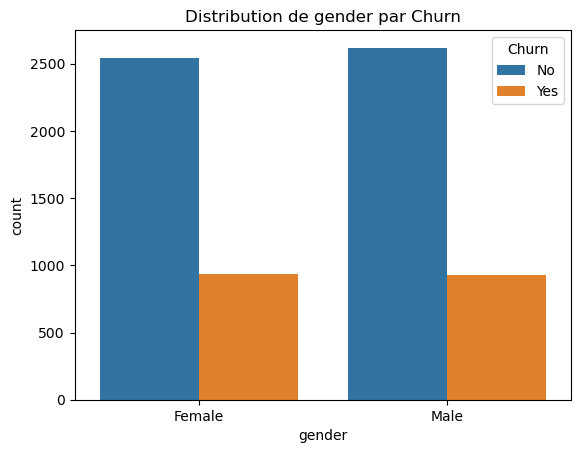

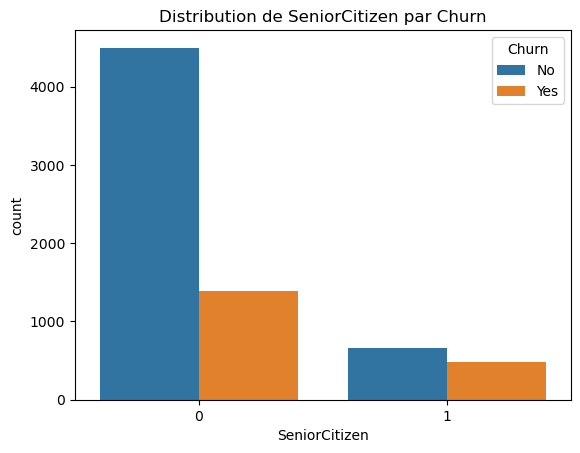

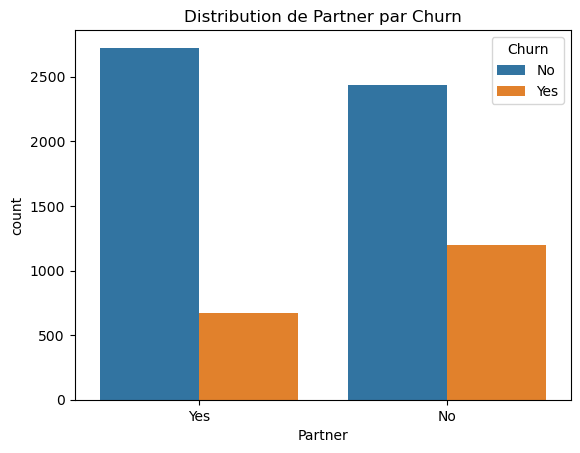

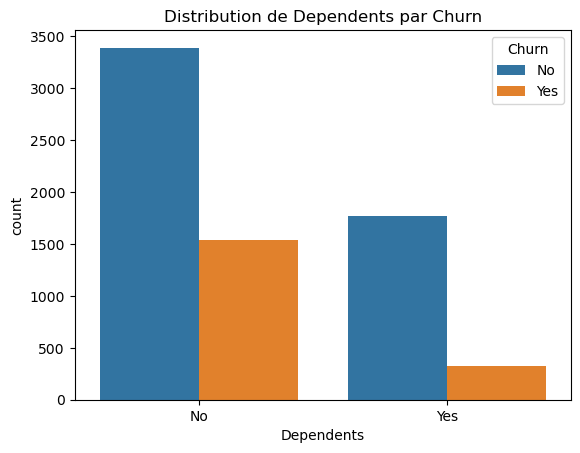

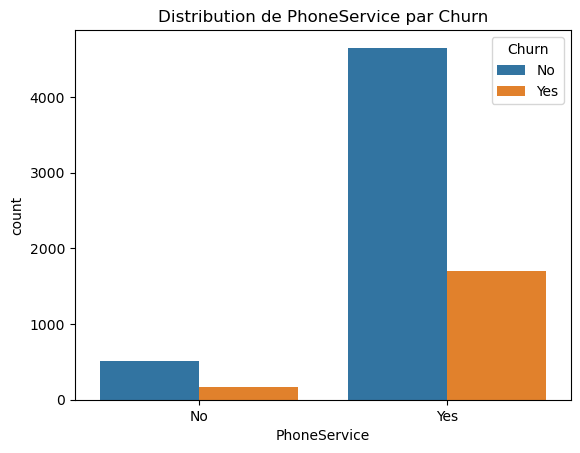

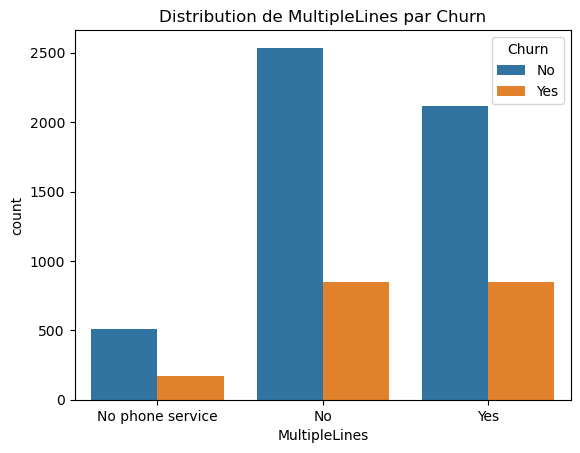

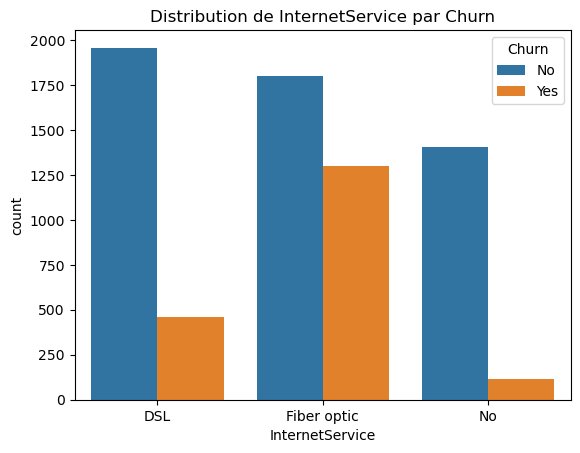

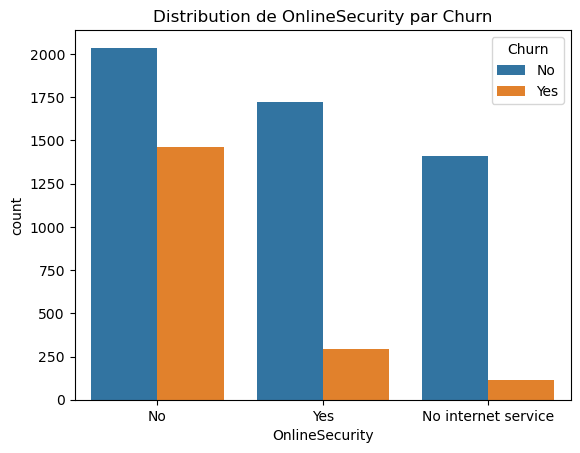

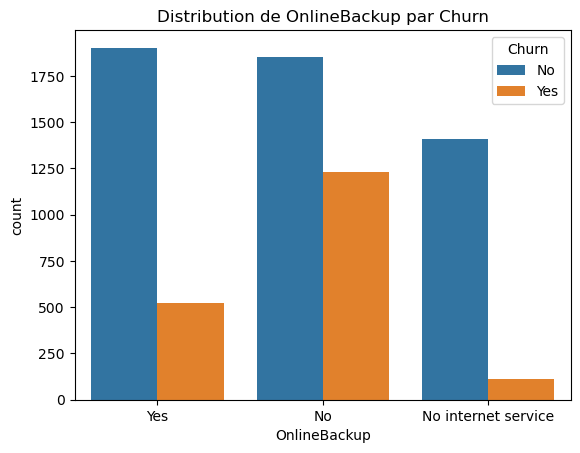

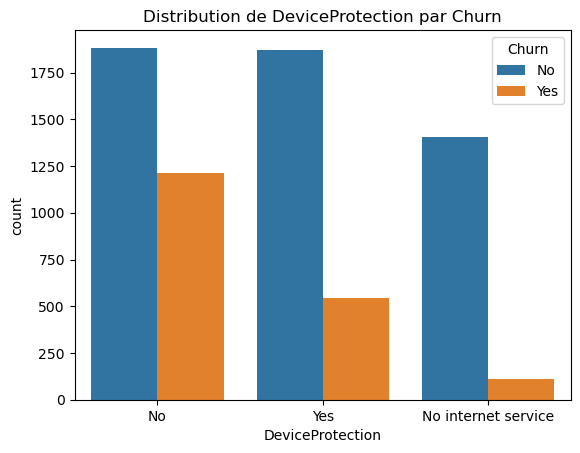

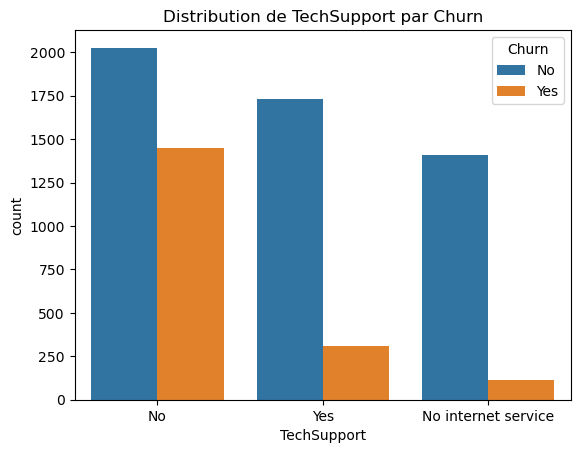

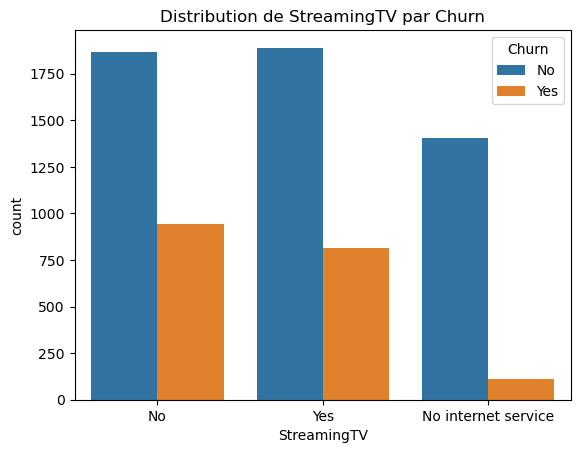

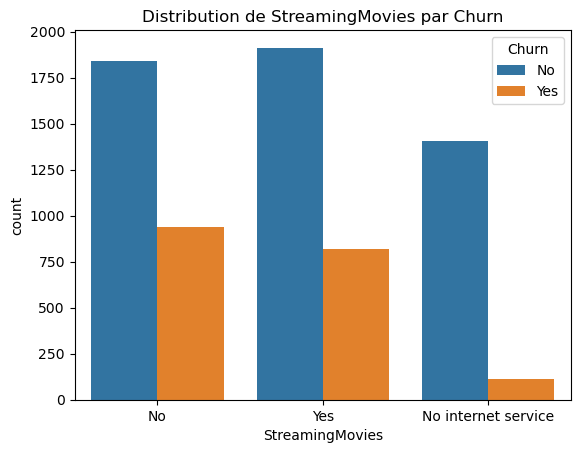

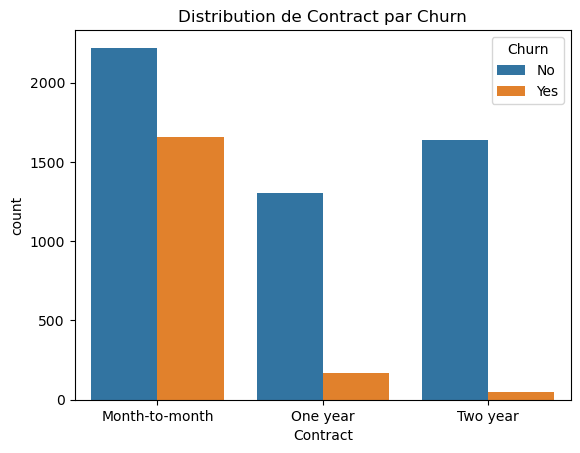

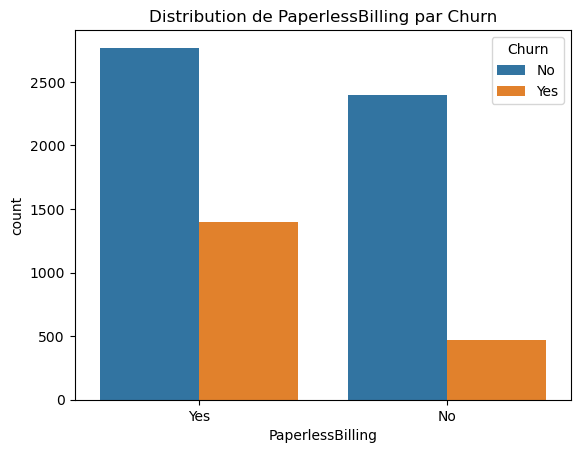

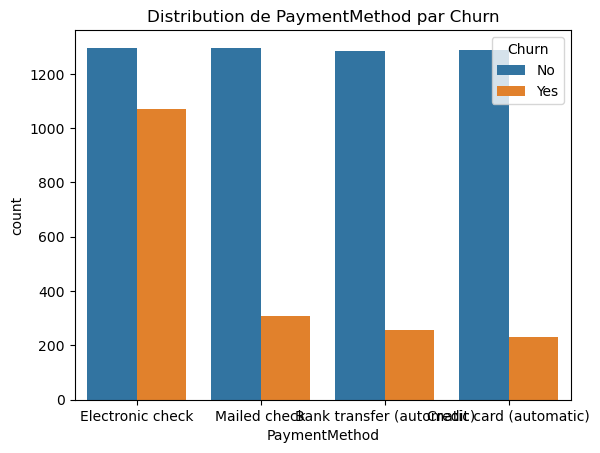

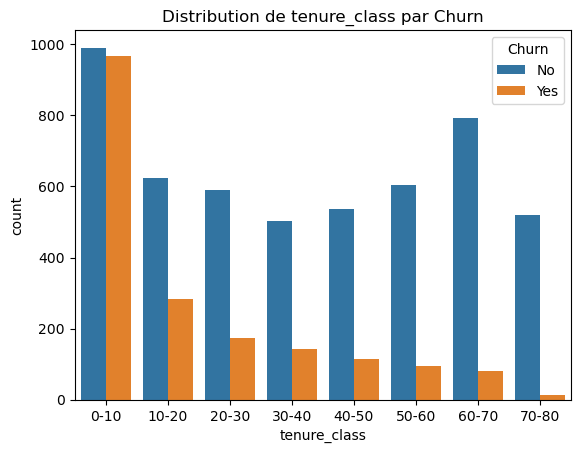

In [21]:
# La distribution des variables individuelles par désabonnement
for i, predictor in enumerate(df.drop(columns=['Churn', 'TotalCharges', 'MonthlyCharges'])):
    plt.figure(i)
    sns.countplot(data=df, x=predictor, hue='Churn')
    plt.title(f'Distribution de {predictor} par Churn')
    plt.show()

In [22]:
# Convertir la variable cible 'Churn' en une variable numérique binaire "Yes=1 ; No=0"
df['Churn'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)
df

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_class
0,Female,0,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,0-10
1,Male,0,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0,30-40
2,Male,0,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,0-10
3,Male,0,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,40-50
4,Female,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,0-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,0,Yes,Yes,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,0,20-30
7039,Female,0,Yes,Yes,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,0,70-80
7040,Female,0,Yes,Yes,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,0,10-20
7041,Male,1,Yes,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,1,0-10


In [23]:
# Encodage des variables catégorielles
df_encoded = pd.get_dummies(df)
df_encoded

,SeniorCitizen,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,...,PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure_class_0-10,tenure_class_10-20,tenure_class_20-30,tenure_class_30-40,tenure_class_40-50,tenure_class_50-60,tenure_class_60-70,tenure_class_70-80
0,0,29.85,29.85,0,True,False,False,True,True,False,...,True,False,True,False,False,False,False,False,False,False
1,0,56.95,1889.50,0,False,True,True,False,True,False,...,False,True,False,False,False,True,False,False,False,False
2,0,53.85,108.15,1,False,True,True,False,True,False,...,False,True,True,False,False,False,False,False,False,False
3,0,42.30,1840.75,0,False,True,True,False,True,False,...,False,False,False,False,False,False,True,False,False,False
4,0,70.70,151.65,1,True,False,True,False,True,False,...,True,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,84.80,1990.50,0,False,True,False,True,False,True,...,False,True,False,False,True,False,False,False,False,False
7039,0,103.20,7362.90,0,True,False,False,True,False,True,...,False,False,False,False,False,False,False,False,False,True
7040,0,29.60,346.45,0,True,False,False,True,False,True,...,True,False,False,True,False,False,False,False,False,False
7041,1,74.40,306.60,1,False,True,False,True,True,False,...,False,True,True,False,False,False,False,False,False,False


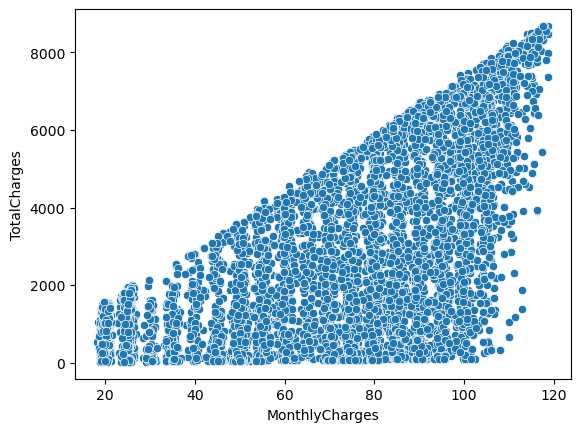

In [24]:
# Relation entre les charges mensuelles et les charges totales
sns.scatterplot(x='MonthlyCharges', y='TotalCharges', data=df_encoded)
plt.show()

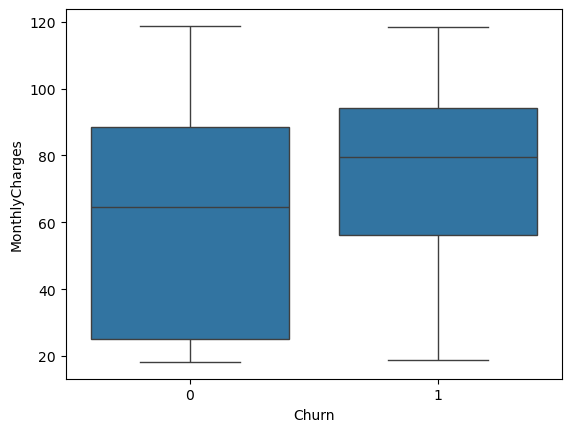

In [25]:
# Désabonnement par charges mensuelles
sns.boxplot(x='Churn', y='MonthlyCharges', data=df_encoded)
plt.show()

Le désabonnement est élevé lorsque les charges mensuelles sont élevées

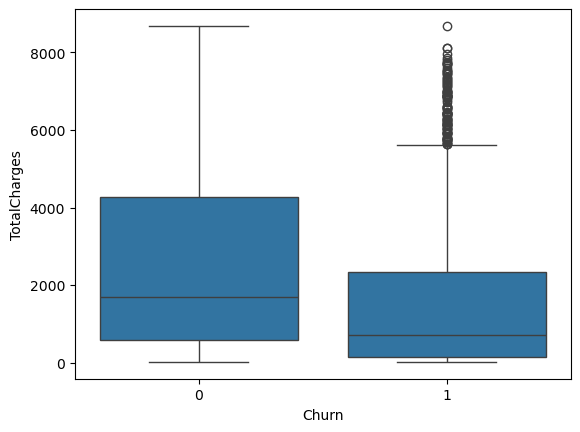

In [27]:
# Désabonnement par charges totales
sns.boxplot(x='Churn', y='TotalCharges', data=df_encoded)
plt.show()

Observation surprenante : La désabonnement est plus élevé pour des charges totales plus faibles

Mais si nous combinons les observations de 3 paramètres, c'est-à-dire ancienneté, charges mensuelles et charges totales, l'image est plus claire : des charges mensuelles plus élevées avec une ancienneté plus faible se traduisent par des charges totales plus faibles.

Ainsi, ces 3 facteurs, à savoir charges mensuelles plus élevées, ancienneté plus faible et charges totales plus faibles sont liés à une désaffection élevée.


In [30]:
df_encoded.corr()

,SeniorCitizen,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,...,PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure_class_0-10,tenure_class_10-20,tenure_class_20-30,tenure_class_30-40,tenure_class_40-50,tenure_class_50-60,tenure_class_60-70,tenure_class_70-80
SeniorCitizen,1.000000,0.219874,0.102411,0.150541,0.001819,-0.001819,-0.016957,0.016957,0.210550,-0.210550,...,0.171322,-0.152987,-0.022485,-0.001678,0.008788,0.015031,0.002812,0.012437,-0.003622,0.000879
MonthlyCharges,0.219874,1.000000,0.651065,0.192858,0.013779,-0.013779,-0.097825,0.097825,0.112343,-0.112343,...,0.271117,-0.376568,-0.181406,-0.060693,-0.017479,0.015721,0.036108,0.059916,0.120585,0.130031
TotalCharges,0.102411,0.651065,1.000000,-0.199484,-0.000048,0.000048,-0.319072,0.319072,-0.064653,0.064653,...,-0.060436,-0.294708,-0.561774,-0.233135,-0.104554,0.007295,0.116954,0.236608,0.436545,0.422297
Churn,0.150541,0.192858,-0.199484,1.000000,0.008545,-0.008545,0.149982,-0.149982,0.163128,-0.163128,...,0.301455,-0.090773,0.321217,0.040000,-0.029803,-0.033940,-0.064699,-0.097452,-0.147817,-0.157520
gender_Female,0.001819,0.013779,-0.000048,0.008545,1.000000,-1.000000,-0.001379,0.001379,0.010349,-0.010349,...,-0.000844,-0.013199,-0.004001,0.014641,-0.009071,-0.006379,0.025556,0.002165,-0.017573,-0.002693
gender_Male,-0.001819,-0.013779,0.000048,-0.008545,-1.000000,1.000000,0.001379,-0.001379,-0.010349,0.010349,...,0.000844,0.013199,0.004001,-0.014641,0.009071,0.006379,-0.025556,-0.002165,0.017573,0.002693
Partner_No,-0.016957,-0.097825,-0.319072,0.149982,-0.001379,0.001379,1.000000,-1.000000,0.452269,-0.452269,...,0.083207,0.096948,0.294702,0.074782,0.012951,-0.015561,-0.054363,-0.096327,-0.171409,-0.210183
Partner_Yes,0.016957,0.097825,0.319072,-0.149982,0.001379,-0.001379,-1.000000,1.000000,-0.452269,0.452269,...,-0.083207,-0.096948,-0.294702,-0.074782,-0.012951,0.015561,0.054363,0.096327,0.171409,0.210183
Dependents_No,0.210550,0.112343,-0.064653,0.163128,0.010349,-0.010349,0.452269,-0.452269,1.000000,-1.000000,...,0.149274,-0.056448,0.146093,0.015784,-0.007244,-0.019889,-0.028269,-0.024582,-0.078917,-0.080150
Dependents_Yes,-0.210550,-0.112343,0.064653,-0.163128,-0.010349,0.010349,-0.452269,0.452269,-1.000000,1.000000,...,-0.149274,0.056448,-0.146093,-0.015784,0.007244,0.019889,0.028269,0.024582,0.078917,0.080150


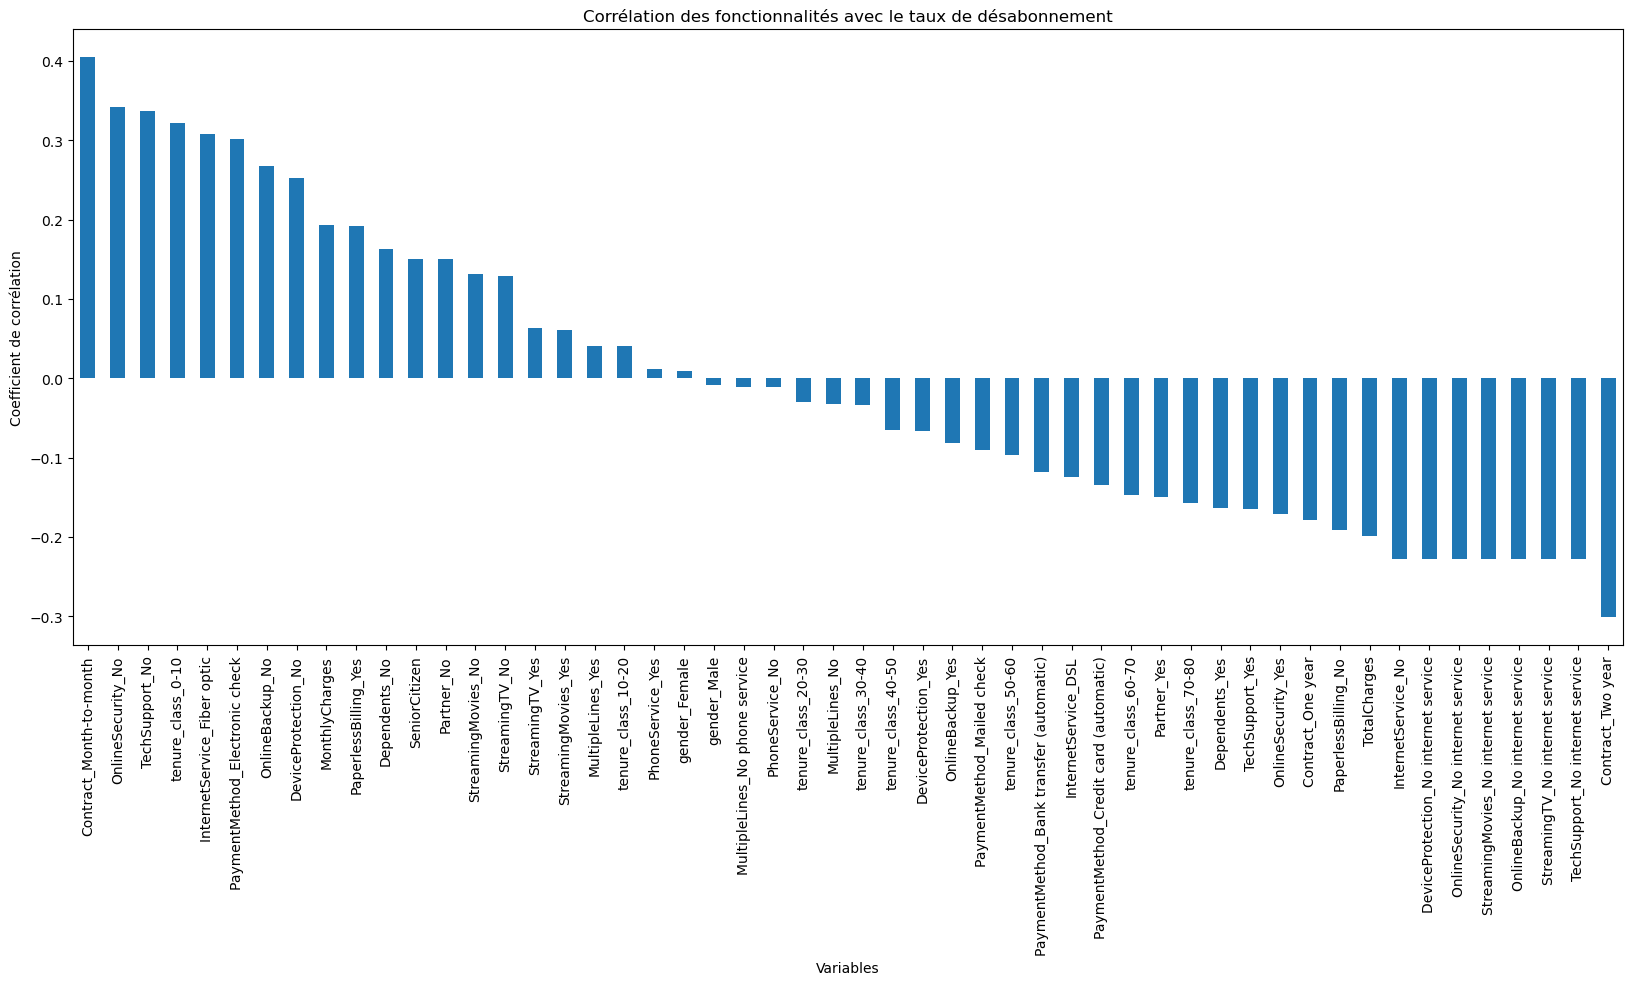

In [31]:
# Trier les corrélations avec la variable cible 'Churn'

plt.figure(figsize=(20,8))
df_encoded.corr()['Churn'].drop(labels='Churn').sort_values(ascending = False).plot(kind='bar')
plt.title('Corrélation des fonctionnalités avec le taux de désabonnement')
plt.ylabel('Coefficient de corrélation')
plt.xlabel('Variables')
plt.show()

Observation dérivée :
Haute désabonnement observée dans le cas des contrats mensuels, absence de sécurité en ligne, absence de support technique, première année d'abonnement et internet par fibre optique

Faible désabonnement observée dans le cas des contrats à long terme, abonnements sans service Internet et clients engagés depuis plus de 5 ans

Des facteurs tels que sexe, disponibilité du service téléphonique et nombre de lignes multiples n'ont presque aucun impact sur la désaffection


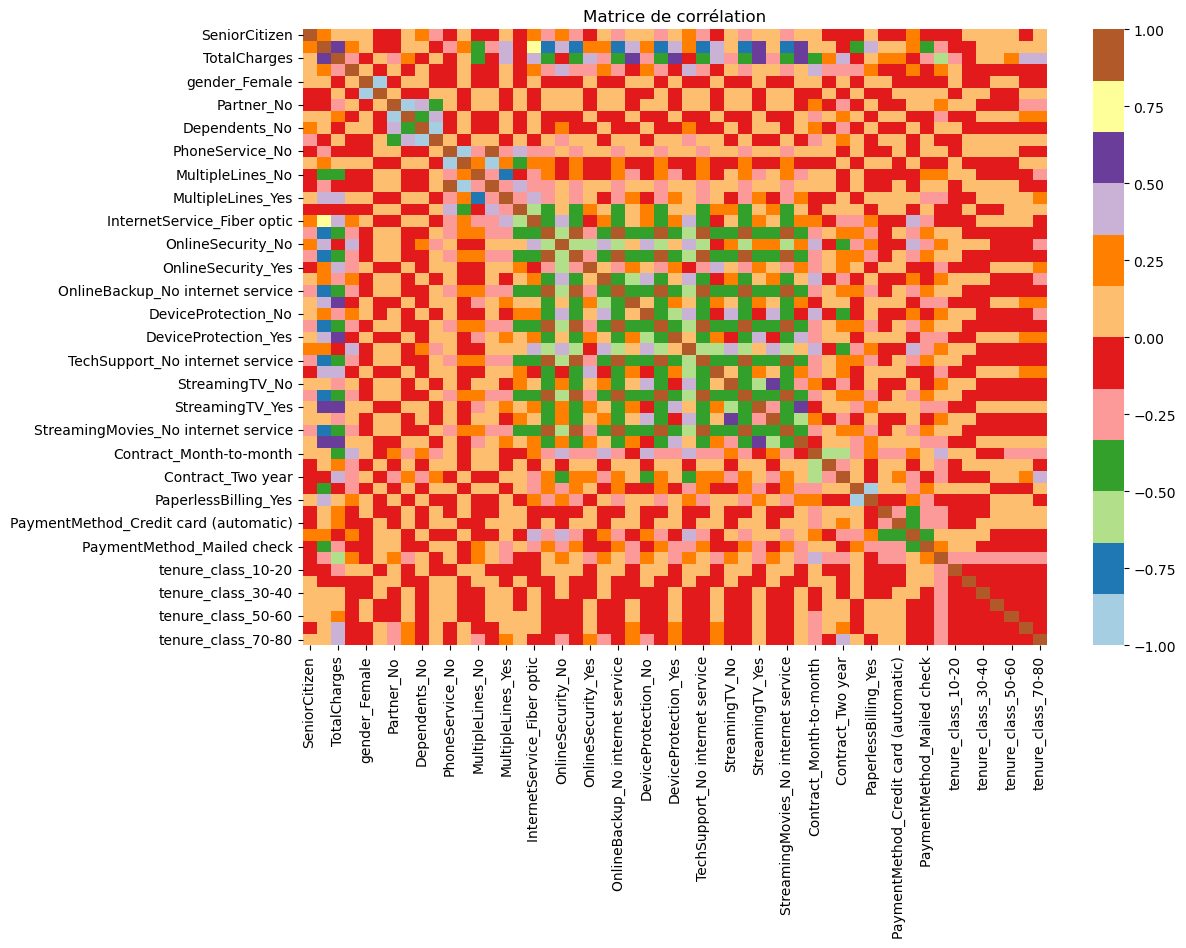

In [33]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_encoded.corr(), cmap="Paired")
plt.title('Matrice de corrélation')
plt.show()

## Modèle de prédiction

### Avant l'entrainement

In [36]:
df

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_class
0,Female,0,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,0-10
1,Male,0,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0,30-40
2,Male,0,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,0-10
3,Male,0,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,40-50
4,Female,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,0-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,0,Yes,Yes,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,0,20-30
7039,Female,0,Yes,Yes,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,0,70-80
7040,Female,0,Yes,Yes,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,0,10-20
7041,Male,1,Yes,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,1,0-10


In [37]:
x=df.drop('Churn',axis=1)
x

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,tenure_class
0,Female,0,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0-10
1,Male,0,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,30-40
2,Male,0,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,0-10
3,Male,0,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,40-50
4,Female,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,0-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,0,Yes,Yes,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,20-30
7039,Female,0,Yes,Yes,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,70-80
7040,Female,0,Yes,Yes,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,10-20
7041,Male,1,Yes,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,0-10


In [38]:
y=df['Churn']
y

0       0
1       0
2       1
3       0
4       1
       ..
7038    0
7039    0
7040    0
7041    1
7042    0
Name: Churn, Length: 7032, dtype: int64

In [39]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

### Arbre de décision

In [41]:
# Création du pipeline
model_adb = make_pipeline(
    OneHotEncoder(handle_unknown='ignore'), 
    DecisionTreeClassifier(class_weight='balanced')
)

In [42]:
# Entraînement du pipeline sur les données d'entraînement
model_adb.fit(x_train, y_train)

Pipeline(steps=[('onehotencoder', OneHotEncoder(handle_unknown='ignore')),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(class_weight='balanced'))])

In [43]:
# Prédiction sur l'ensemble de test
y_pred_adb = model_adb.predict(x_test)
y_pred_adb

array([0, 0, 1, ..., 0, 0, 0], dtype=int64)

In [44]:
# Evaluation

print("Score: {:.2f}".format(model_adb.score(x_test, y_test)))
print('\n')
print(classification_report(y_test, y_pred_adb, labels=[0,1]))
print('\n')
print(metrics.confusion_matrix(y_test, y_pred_adb))
print('\n')
auc_adb = roc_auc_score(y_test, y_pred_adb)
mae = mean_absolute_error(y_test, y_pred_adb)
f1_adb = f1_score(y_test, y_pred_adb)

print(f'Decision Tree: AUC = {auc_adb:.2f}, F1 = {f1_adb:.2f}, Mean Absolute Error (MAE): {mae:.2f}')

Score: 0.74


              precision    recall  f1-score   support

           0       0.85      0.79      0.82      1033
           1       0.51      0.62      0.56       374

    accuracy                           0.74      1407
   macro avg       0.68      0.70      0.69      1407
weighted avg       0.76      0.74      0.75      1407



[[812 221]
 [143 231]]


Decision Tree: AUC = 0.70, F1 = 0.56, Mean Absolute Error (MAE): 0.26


#### Technique d'amélioration

In [46]:
# en_df = OneHotEncoder(handle_unknown='ignore').fit(df)
en_df = pd.DataFrame(OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit_transform(df), columns=OneHotEncoder().fit(df).get_feature_names_out(df.columns))

en_df

,gender_Female,gender_Male,SeniorCitizen_0,SeniorCitizen_1,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,...,Churn_0,Churn_1,tenure_class_0-10,tenure_class_10-20,tenure_class_20-30,tenure_class_30-40,tenure_class_40-50,tenure_class_50-60,tenure_class_60-70,tenure_class_70-80
0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
7028,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7029,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7030,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### SMOTEENN

In [48]:
# en_df = pd.OneHotEncoder(df, handle_unknown='ignore')
x=df.drop('Churn',axis=1)
y=df['Churn']
x = pd.DataFrame(OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit_transform(x), columns=OneHotEncoder().fit(x).get_feature_names_out(x.columns))
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
X_resampled, y_resampled = SMOTEENN().fit_resample(x_train,y_train)

In [49]:
xr_train, xr_test, yr_train, yr_test =train_test_split(X_resampled, y_resampled, test_size=0.2)

In [50]:
model_adse = DecisionTreeClassifier()

In [51]:
model_adse.fit(xr_train, yr_train)

DecisionTreeClassifier()

In [52]:
# Prédiction sur l'ensemble de test
y_pred_adse = model_adse.predict(xr_test)
y_pred_adse

array([1, 1, 1, ..., 1, 0, 1], dtype=int64)

In [53]:
# Evaluation

print("Score: {:.2f}".format(model_adse.score(xr_test, yr_test)))
print('\n')
print(classification_report(yr_test, y_pred_adse, labels=[0,1]))
print('\n')
print(metrics.confusion_matrix(yr_test, y_pred_adse))
print('\n')
auc_adse = roc_auc_score(yr_test, y_pred_adse)
mae = mean_absolute_error(yr_test, y_pred_adse)
f1_adse = f1_score(yr_test, y_pred_adse)

print(f'Decision Tree avec SMOTEENN: AUC = {auc_adse:.2f}, F1 = {f1_adse:.2f}, Mean Absolute Error (MAE): {mae:.2f}')

Score: 0.96


              precision    recall  f1-score   support

           0       0.94      0.93      0.94       349
           1       0.97      0.97      0.97       727

    accuracy                           0.96      1076
   macro avg       0.95      0.95      0.95      1076
weighted avg       0.96      0.96      0.96      1076



[[326  23]
 [ 22 705]]


Decision Tree avec SMOTEENN: AUC = 0.95, F1 = 0.97, Mean Absolute Error (MAE): 0.04


##### SMOTE

In [55]:
# en_df = pd.OneHotEncoder(df, handle_unknown='ignore')
x=df.drop('Churn',axis=1)
y=df['Churn']
x = pd.DataFrame(OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit_transform(x), columns=OneHotEncoder().fit(x).get_feature_names_out(x.columns))
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
X_resampled, y_resampled = SMOTE().fit_resample(x_train,y_train)

In [56]:
xr_train, xr_test, yr_train, yr_test =train_test_split(X_resampled, y_resampled, test_size=0.2)

In [57]:
model_ads = DecisionTreeClassifier()

In [58]:
model_ads.fit(xr_train, yr_train)

DecisionTreeClassifier()

In [59]:
# Prédiction sur l'ensemble de test
y_pred_ads = model_ads.predict(xr_test)
y_pred_ads

array([1, 1, 1, ..., 1, 0, 0], dtype=int64)

In [60]:
# Evaluation

print("Score: {:.2f}".format(model_ads.score(xr_test, yr_test)))
print('\n')
print(classification_report(yr_test, y_pred_ads, labels=[0,1]))
print('\n')
print(metrics.confusion_matrix(yr_test, y_pred_ads))
print('\n')
auc_ads = roc_auc_score(yr_test, y_pred_ads)
mae = mean_absolute_error(yr_test, y_pred_ads)
f1_ads = f1_score(yr_test, y_pred_ads)

print(f'Decision Tree avec SMOTE: AUC = {auc_ads:.2f}, F1 = {f1_ads:.2f}, Mean Absolute Error (MAE): {mae:.2f}')

Score: 0.84


              precision    recall  f1-score   support

           0       0.84      0.84      0.84       830
           1       0.84      0.84      0.84       822

    accuracy                           0.84      1652
   macro avg       0.84      0.84      0.84      1652
weighted avg       0.84      0.84      0.84      1652



[[700 130]
 [132 690]]


Decision Tree avec SMOTE: AUC = 0.84, F1 = 0.84, Mean Absolute Error (MAE): 0.16


### Random Forest Classifier

In [62]:
# Création du pipeline
model_rfb = make_pipeline(
    OneHotEncoder(handle_unknown='ignore'), 
    RandomForestClassifier(class_weight='balanced')
)

In [63]:
# Entraînement du pipeline sur les données d'entraînement
model_rfb.fit(x_train, y_train)

Pipeline(steps=[('onehotencoder', OneHotEncoder(handle_unknown='ignore')),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced'))])

In [64]:
# Prédiction sur l'ensemble de test
y_pred_rfb = model_rfb.predict(x_test)
y_pred_rfb

array([0, 0, 1, ..., 0, 0, 0], dtype=int64)

In [65]:
# Evaluation

print("Score: {:.2f}".format(model_rfb.score(x_test, y_test)))
print('\n')
print(classification_report(y_test, y_pred_rfb, labels=[0,1]))
print('\n')
print(metrics.confusion_matrix(y_test, y_pred_rfb))
print('\n')
auc_rfb = roc_auc_score(y_test, y_pred_rfb)
mae = mean_absolute_error(y_test, y_pred_rfb)
f1_rfb = f1_score(y_test, y_pred_rfb)

print(f'Random Forest: AUC = {auc_rfb:.2f}, F1 = {f1_rfb:.2f}, Mean Absolute Error (MAE): {mae:.2f}')

Score: 0.78


              precision    recall  f1-score   support

           0       0.83      0.88      0.85      1033
           1       0.60      0.50      0.54       374

    accuracy                           0.78      1407
   macro avg       0.72      0.69      0.70      1407
weighted avg       0.77      0.78      0.77      1407



[[910 123]
 [188 186]]


Random Forest: AUC = 0.69, F1 = 0.54, Mean Absolute Error (MAE): 0.22


#### Technique d'amélioration

In [67]:
# en_df = OneHotEncoder(handle_unknown='ignore').fit(df)
en_df = pd.DataFrame(OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit_transform(df), columns=OneHotEncoder().fit(df).get_feature_names_out(df.columns))

en_df

,gender_Female,gender_Male,SeniorCitizen_0,SeniorCitizen_1,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,...,Churn_0,Churn_1,tenure_class_0-10,tenure_class_10-20,tenure_class_20-30,tenure_class_30-40,tenure_class_40-50,tenure_class_50-60,tenure_class_60-70,tenure_class_70-80
0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
7028,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7029,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7030,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### SMOTEENN

In [69]:
# en_df = pd.OneHotEncoder(df, handle_unknown='ignore')
x=df.drop('Churn',axis=1)
y=df['Churn']
x = pd.DataFrame(OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit_transform(x), columns=OneHotEncoder().fit(x).get_feature_names_out(x.columns))
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
X_resampled, y_resampled = SMOTEENN().fit_resample(x_train,y_train)

In [70]:
xr_train, xr_test, yr_train, yr_test =train_test_split(X_resampled, y_resampled, test_size=0.2)

In [71]:
model_rfbse = RandomForestClassifier()

In [72]:
model_rfbse.fit(xr_train, yr_train)

RandomForestClassifier()

In [73]:
# Prédiction sur l'ensemble de test
y_pred_rfbse = model_rfbse.predict(xr_test)
y_pred_rfbse

array([0, 1, 0, ..., 1, 1, 0], dtype=int64)

In [74]:
# Evaluation

print("Score: {:.2f}".format(model_rfbse.score(xr_test, yr_test)))
print('\n')
print(classification_report(yr_test, y_pred_rfbse, labels=[0,1]))
print('\n')
print(metrics.confusion_matrix(yr_test, y_pred_rfbse))
print('\n')
auc_rfbse = roc_auc_score(yr_test, y_pred_rfbse)
mae = mean_absolute_error(yr_test, y_pred_rfbse)
f1_rfbse = f1_score(yr_test, y_pred_rfbse)

print(f'Random Forest avec SMOTEENN: AUC = {auc_rfbse:.2f}, F1 = {f1_rfbse:.2f}, Mean Absolute Error (MAE): {mae:.2f}')

Score: 0.98


              precision    recall  f1-score   support

           0       0.97      0.96      0.96       317
           1       0.98      0.99      0.99       749

    accuracy                           0.98      1066
   macro avg       0.98      0.97      0.98      1066
weighted avg       0.98      0.98      0.98      1066



[[303  14]
 [  8 741]]


Random Forest avec SMOTEENN: AUC = 0.97, F1 = 0.99, Mean Absolute Error (MAE): 0.02


##### SMOTE

In [76]:
# en_df = pd.OneHotEncoder(df, handle_unknown='ignore')
x=df.drop('Churn',axis=1)
y=df['Churn']
x = pd.DataFrame(OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit_transform(x), columns=OneHotEncoder().fit(x).get_feature_names_out(x.columns))
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
X_resampled, y_resampled = SMOTE().fit_resample(x_train,y_train)

In [77]:
xr_train, xr_test, yr_train, yr_test =train_test_split(X_resampled, y_resampled, test_size=0.2)

In [78]:
model_rfbs = RandomForestClassifier()

In [79]:
model_rfbs.fit(xr_train, yr_train)

RandomForestClassifier()

In [80]:
# Prédiction sur l'ensemble de test
y_pred_rfbs = model_rfbs.predict(xr_test)
y_pred_rfbs

array([1, 1, 1, ..., 1, 0, 0], dtype=int64)

In [81]:
# Evaluation

print("Score: {:.2f}".format(model_rfbs.score(xr_test, yr_test)))
print('\n')
print(classification_report(yr_test, y_pred_rfbs, labels=[0,1]))
print('\n')
print(metrics.confusion_matrix(yr_test, y_pred_rfbs))
print('\n')
auc_rfbs = roc_auc_score(yr_test, y_pred_rfbs)
mae = mean_absolute_error(yr_test, y_pred_rfbs)
f1_rfbs = f1_score(yr_test, y_pred_rfbs)

print(f'Random Forest avec SMOTE: AUC = {auc_rfbs:.2f}, F1 = {f1_rfbs:.2f}, Mean Absolute Error (MAE): {mae:.2f}')

Score: 0.88


              precision    recall  f1-score   support

           0       0.86      0.90      0.88       815
           1       0.90      0.86      0.88       837

    accuracy                           0.88      1652
   macro avg       0.88      0.88      0.88      1652
weighted avg       0.88      0.88      0.88      1652



[[737  78]
 [118 719]]


Random Forest avec SMOTE: AUC = 0.88, F1 = 0.88, Mean Absolute Error (MAE): 0.12


### XGBoost

In [83]:
# Création du pipeline
model_xgb = make_pipeline(
    OneHotEncoder(handle_unknown='ignore'), 
    XGBClassifier()
)

In [84]:
# Entraînement du pipeline sur les données d'entraînement
model_xgb.fit(x_train, y_train)

Pipeline(steps=[('onehotencoder', OneHotEncoder(handle_unknown='ignore')),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [85]:
# Prédiction sur l'ensemble de test
y_pred_xgb = model_xgb.predict(x_test)
y_pred_xgb

array([0, 0, 1, ..., 0, 0, 0])

In [86]:
# Evaluation

print("Score: {:.2f}".format(model_xgb.score(x_test, y_test)))
print('\n')
print(classification_report(y_test, y_pred_xgb, labels=[0,1]))
print('\n')
print(metrics.confusion_matrix(y_test, y_pred_xgb))
print('\n')
auc_xgb = roc_auc_score(y_test, y_pred_xgb)
mae = mean_absolute_error(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)

print(f'XGBoost: AUC = {auc_xgb:.2f}, F1 = {f1_xgb:.2f}, Mean Absolute Error (MAE): {mae:.2f}')

Score: 0.78


              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1033
           1       0.61      0.49      0.55       374

    accuracy                           0.78      1407
   macro avg       0.72      0.69      0.70      1407
weighted avg       0.77      0.78      0.77      1407



[[917 116]
 [190 184]]


XGBoost: AUC = 0.69, F1 = 0.55, Mean Absolute Error (MAE): 0.22


#### Technique d'amélioration

In [88]:
# en_df = OneHotEncoder(handle_unknown='ignore').fit(df)
en_df = pd.DataFrame(OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit_transform(df), columns=OneHotEncoder().fit(df).get_feature_names_out(df.columns))

en_df

,gender_Female,gender_Male,SeniorCitizen_0,SeniorCitizen_1,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,...,Churn_0,Churn_1,tenure_class_0-10,tenure_class_10-20,tenure_class_20-30,tenure_class_30-40,tenure_class_40-50,tenure_class_50-60,tenure_class_60-70,tenure_class_70-80
0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
7028,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7029,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7030,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### SMOTEENN

In [90]:
# en_df = pd.OneHotEncoder(df, handle_unknown='ignore')
x=df.drop('Churn',axis=1)
y=df['Churn']
x = pd.DataFrame(OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit_transform(x), columns=OneHotEncoder().fit(x).get_feature_names_out(x.columns))
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
X_resampled, y_resampled = SMOTEENN().fit_resample(x_train,y_train)

In [91]:
xr_train, xr_test, yr_train, yr_test =train_test_split(X_resampled, y_resampled, test_size=0.2)

In [92]:
model_xgbse = XGBClassifier(scale_pos_weight=len(xr_train)/sum(yr_train))

In [93]:
model_xgbse.fit(xr_train, yr_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [94]:
# Prédiction sur l'ensemble de test
y_pred_xgbse = model_xgbse.predict(xr_test)
y_pred_xgbse

array([0, 0, 1, ..., 1, 0, 1])

In [95]:
# Evaluation

print("Score: {:.2f}".format(model_xgbse.score(xr_test, yr_test)))
print('\n')
print(classification_report(yr_test, y_pred_xgbse, labels=[0,1]))
print('\n')
print(metrics.confusion_matrix(yr_test, y_pred_xgbse))
print('\n')
auc_xgbse = roc_auc_score(yr_test, y_pred_xgbse)
mae = mean_absolute_error(yr_test, y_pred_xgbse)
f1_xgbse = f1_score(yr_test, y_pred_xgbse)

print(f'XGBoost avec SMOTEENN: AUC = {auc_xgbse:.2f}, F1 = {f1_xgbse:.2f}, Mean Absolute Error (MAE): {mae:.2f}')

Score: 0.97


              precision    recall  f1-score   support

           0       0.97      0.94      0.95       344
           1       0.97      0.99      0.98       739

    accuracy                           0.97      1083
   macro avg       0.97      0.96      0.96      1083
weighted avg       0.97      0.97      0.97      1083



[[322  22]
 [ 11 728]]


XGBoost avec SMOTEENN: AUC = 0.96, F1 = 0.98, Mean Absolute Error (MAE): 0.03


##### SMOTE

In [97]:
# en_df = pd.OneHotEncoder(df, handle_unknown='ignore')
x=df.drop('Churn',axis=1)
y=df['Churn']
x = pd.DataFrame(OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit_transform(x), columns=OneHotEncoder().fit(x).get_feature_names_out(x.columns))
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
X_resampled, y_resampled = SMOTE().fit_resample(x_train,y_train)

In [98]:
xr_train, xr_test, yr_train, yr_test =train_test_split(X_resampled, y_resampled, test_size=0.2)

In [99]:
model_xgbs = XGBClassifier(scale_pos_weight=len(xr_train)/sum(yr_train))

In [100]:
model_xgbs.fit(xr_train, yr_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [101]:
# Prédiction sur l'ensemble de test
y_pred_xgbs = model_xgbs.predict(xr_test)
y_pred_xgbs

array([0, 1, 0, ..., 0, 1, 0])

In [102]:
# Evaluation

print("Score: {:.2f}".format(model_xgbs.score(xr_test, yr_test)))
print('\n')
print(classification_report(yr_test, y_pred_xgbs, labels=[0,1]))
print('\n')
print(metrics.confusion_matrix(yr_test, y_pred_xgbs))
print('\n')
auc_xgbs = roc_auc_score(yr_test, y_pred_xgbs)
mae = mean_absolute_error(yr_test, y_pred_xgbs)
f1_xgbs = f1_score(yr_test, y_pred_xgbs)

print(f'XGBoost avec SMOTE: AUC = {auc_xgbs:.2f}, F1 = {f1_xgbs:.2f}, Mean Absolute Error (MAE): {mae:.2f}')

Score: 0.84


              precision    recall  f1-score   support

           0       0.89      0.78      0.83       844
           1       0.80      0.90      0.85       808

    accuracy                           0.84      1652
   macro avg       0.84      0.84      0.84      1652
weighted avg       0.84      0.84      0.84      1652



[[662 182]
 [ 83 725]]


XGBoost avec SMOTE: AUC = 0.84, F1 = 0.85, Mean Absolute Error (MAE): 0.16


### Ensemble Learning

In [104]:
# Création du pipeline
ensemble_model = make_pipeline(
    OneHotEncoder(handle_unknown='ignore'), 
    VotingClassifier(estimators=[
    ('rf', RandomForestClassifier(class_weight='balanced', random_state=42)),
    ('xgb', XGBClassifier(scale_pos_weight=len(y_train)/sum(y_train))),
    ('dt', DecisionTreeClassifier(class_weight='balanced'))
], voting='soft')
)

In [105]:
ensemble_model.fit(x_train, y_train)

Pipeline(steps=[('onehotencoder', OneHotEncoder(handle_unknown='ignore')),
                ('votingclassifier',
                 VotingClassifier(estimators=[('rf',
                                               RandomForestClassifier(class_weight='balanced',
                                                                      random_state=42)),
                                              ('xgb',
                                               XGBClassifier(base_score=None,
                                                             booster=None,
                                                             callbacks=None,
                                                             colsample_bylevel=None,
                                                             colsample_bynode=None,
                                                             colsample_bytree=None,
                                                             device=None,
                                                             early_stoppin...
                                                             learning_rate=None,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=None,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=None,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             random_state=None, ...)),
                                              ('dt',
                                               DecisionTreeClassifier(class_weight='balanced'))],
                                  voting='soft'))])

In [106]:
y_pred_ensemble = ensemble_model.predict(x_test)

In [107]:
# Evaluation

print("Score: {:.2f}".format(ensemble_model.score(x_test, y_test)))
print('\n')
print(classification_report(y_test, y_pred_ensemble, labels=[0,1]))
print('\n')
print(metrics.confusion_matrix(y_test, y_pred_ensemble))
print('\n')
auc_ens = roc_auc_score(y_test, y_pred_ensemble)
mae = mean_absolute_error(y_test, y_pred_ensemble)
f1_ens = f1_score(y_test, y_pred_ensemble)

print(f'Ensemble learning: AUC = {auc_ens:.2f}, F1 = {f1_ens:.2f}, Mean Absolute Error (MAE): {mae:.2f}')

Score: 0.75


              precision    recall  f1-score   support

           0       0.86      0.78      0.82      1033
           1       0.52      0.64      0.57       374

    accuracy                           0.75      1407
   macro avg       0.69      0.71      0.70      1407
weighted avg       0.77      0.75      0.75      1407



[[809 224]
 [134 240]]


Ensemble learning: AUC = 0.71, F1 = 0.57, Mean Absolute Error (MAE): 0.25


#### Technique d'amélioration

In [109]:
# en_df = OneHotEncoder(handle_unknown='ignore').fit(df)
en_df = pd.DataFrame(OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit_transform(df), columns=OneHotEncoder().fit(df).get_feature_names_out(df.columns))

en_df

,gender_Female,gender_Male,SeniorCitizen_0,SeniorCitizen_1,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,...,Churn_0,Churn_1,tenure_class_0-10,tenure_class_10-20,tenure_class_20-30,tenure_class_30-40,tenure_class_40-50,tenure_class_50-60,tenure_class_60-70,tenure_class_70-80
0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
7028,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7029,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7030,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### SMOTEENN

In [111]:
# en_df = pd.OneHotEncoder(df, handle_unknown='ignore')
x=df.drop('Churn',axis=1)
y=df['Churn']
x = pd.DataFrame(OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit_transform(x), columns=OneHotEncoder().fit(x).get_feature_names_out(x.columns))
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
X_resampled, y_resampled = SMOTEENN().fit_resample(x_train,y_train)

In [112]:
xr_train, xr_test, yr_train, yr_test =train_test_split(X_resampled, y_resampled, test_size=0.2)

In [113]:
ensemble_model_se = VotingClassifier(estimators=[
    ('rf', RandomForestClassifier(class_weight='balanced', random_state=42)),
    ('xgb', XGBClassifier(scale_pos_weight=len(y_train)/sum(y_train))),
    ('dt', DecisionTreeClassifier(class_weight='balanced'))
], voting='soft')

In [114]:
ensemble_model_se.fit(xr_train, yr_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(class_weight='balanced',
                                                     random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_po...
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('dt',
                              DecisionTreeClassifier(class_weight='balanced'))],
                 voting='soft')

In [115]:
# Prédiction sur l'ensemble de test
y_pred_ensemble_model_se = ensemble_model_se.predict(xr_test)
y_pred_ensemble_model_se

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

In [116]:
# Evaluation

print("Score: {:.2f}".format(ensemble_model_se.score(xr_test, yr_test)))
print('\n')
print(classification_report(yr_test, y_pred_ensemble_model_se, labels=[0,1]))
print('\n')
print(metrics.confusion_matrix(yr_test, y_pred_ensemble_model_se))
print('\n')
auc_ensemble_model_se = roc_auc_score(yr_test, y_pred_ensemble_model_se)
mae = mean_absolute_error(yr_test, y_pred_ensemble_model_se)
f1_ensemble_model_se = f1_score(yr_test, y_pred_ensemble_model_se)

print(f'Ensemble model avec SMOTEENN: AUC = {auc_ensemble_model_se:.2f}, F1 = {f1_ensemble_model_se:.2f}, Mean Absolute Error (MAE): {mae:.2f}')

Score: 0.98


              precision    recall  f1-score   support

           0       0.95      0.97      0.96       327
           1       0.99      0.98      0.98       744

    accuracy                           0.98      1071
   macro avg       0.97      0.97      0.97      1071
weighted avg       0.98      0.98      0.98      1071



[[317  10]
 [ 15 729]]


Ensemble model avec SMOTEENN: AUC = 0.97, F1 = 0.98, Mean Absolute Error (MAE): 0.02


##### SMOTE

In [118]:
# en_df = pd.OneHotEncoder(df, handle_unknown='ignore')
x=df.drop('Churn',axis=1)
y=df['Churn']
x = pd.DataFrame(OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit_transform(x), columns=OneHotEncoder().fit(x).get_feature_names_out(x.columns))
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
X_resampled, y_resampled = SMOTE().fit_resample(x_train,y_train)

In [119]:
xr_train, xr_test, yr_train, yr_test =train_test_split(X_resampled, y_resampled, test_size=0.2)

In [120]:
ensemble_model_s = VotingClassifier(estimators=[
    ('rf', RandomForestClassifier(class_weight='balanced', random_state=42)),
    ('xgb', XGBClassifier(scale_pos_weight=len(y_train)/sum(y_train))),
    ('dt', DecisionTreeClassifier(class_weight='balanced'))
], voting='soft')

In [121]:
ensemble_model_s.fit(xr_train, yr_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(class_weight='balanced',
                                                     random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_po...
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('dt',
                              DecisionTreeClassifier(class_weight='balanced'))],
                 voting='soft')

In [122]:
# Prédiction sur l'ensemble de test
y_pred_ensemble_model_s = ensemble_model_s.predict(xr_test)
y_pred_ensemble_model_s

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [123]:
# Evaluation

print("Score: {:.2f}".format(ensemble_model_s.score(xr_test, yr_test)))
print('\n')
print(classification_report(yr_test, y_pred_ensemble_model_s, labels=[0,1]))
print('\n')
print(metrics.confusion_matrix(yr_test, y_pred_ensemble_model_s))
print('\n')
auc_ensemble_model_s = roc_auc_score(yr_test, y_pred_ensemble_model_s)
mae = mean_absolute_error(yr_test, y_pred_ensemble_model_s)
f1_ensemble_model_s = f1_score(yr_test, y_pred_ensemble_model_s)

print(f'Ensemble model avec SMOTE: AUC = {auc_ensemble_model_s:.2f}, F1 = {f1_ensemble_model_s:.2f}, Mean Absolute Error (MAE): {mae:.2f}')

Score: 0.86


              precision    recall  f1-score   support

           0       0.87      0.86      0.86       848
           1       0.85      0.86      0.86       804

    accuracy                           0.86      1652
   macro avg       0.86      0.86      0.86      1652
weighted avg       0.86      0.86      0.86      1652



[[730 118]
 [110 694]]


Ensemble model avec SMOTE: AUC = 0.86, F1 = 0.86, Mean Absolute Error (MAE): 0.14


### Chargement du modèle

In [222]:
joblib.dump(model_rfbse, 'model.joblib')

['model.joblib']